In [1]:
import pandas as pd
import numpy as np
import pysd
import pandas as pd
import datetime as dt
import scipy.optimize
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter
from math import sqrt
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

%matplotlib inline

In [2]:
policies_data = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv',parse_dates=['Date'] )
dates = pd.date_range(start="01-01-2020",end =(dt.datetime.now().date() - dt.timedelta(days=1)))
lookup_countries = pd.read_excel('../../../data/states_us.xlsx')
from_names_to_pop = lookup_countries.set_index(['State'])['pop'].to_dict()
policies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31328 entries, 0 to 31327
Data columns (total 42 columns):
CountryName                              31328 non-null object
CountryCode                              31328 non-null object
Date                                     31328 non-null datetime64[ns]
C1_School closing                        29874 non-null float64
C1_Flag                                  16241 non-null float64
C2_Workplace closing                     29864 non-null float64
C2_Flag                                  14594 non-null float64
C3_Cancel public events                  29859 non-null float64
C3_Flag                                  16658 non-null float64
C4_Restrictions on gatherings            29869 non-null float64
C4_Flag                                  14755 non-null float64
C5_Close public transport                29858 non-null float64
C5_Flag                                  10525 non-null float64
C6_Stay at home requirements             29868 non-nul

In [3]:
policies_data.CountryName.unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei', 'Bhutan', 'Botswana', 'Central African Republic',
       'Canada', 'Switzerland', 'Chile', 'China', "Cote d'Ivoire",
       'Cameroon', 'Democratic Republic of Congo', 'Congo', 'Colombia',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic',
       'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic',
       'Algeria', 'Ecuador', 'Egypt', 'Eritrea', 'Spain', 'Estonia',
       'Ethiopia', 'Finland', 'Fiji', 'France', 'Gabon', 'United Kingdom',
       'Georgia', 'Ghana', 'Gibraltar', 'Guinea', 'Gambia', 'Greece',
       'Greenland', 'Guatemala', 'Guam', 'Guyana', 'Hong Kong',
       'Honduras', 'Croatia',

In [4]:
country = 'New York'
data_timeseries = pd.read_json('../../../data/corrected/USA/'+country+'.json')
data_timeseries = data_timeseries.reindex(dates, fill_value=0)
data_timeseries = data_timeseries.reset_index().rename(columns={"index": "Date"})
data_timeseries = data_timeseries.sort_index()

In [5]:
policies_data_per_country = policies_data[policies_data['CountryName']=='United States'][['Date','C1_School closing',\
                                                      'C2_Workplace closing',\
                                                      'C3_Cancel public events',\
                                                      'C4_Restrictions on gatherings',\
                                                      'C5_Close public transport',\
                                                      'C6_Stay at home requirements',\
                                                      'C7_Restrictions on internal movement',\
                                                      'E1_Income support',\
                                                      'E2_Debt/contract relief',
                                                      'E3_Fiscal measures',\
                                                      'E4_International support',
                                                      'H1_Public information campaigns',
                                                      'H2_Testing policy',
                                                      'H4_Emergency investment in healthcare',
                                                      'H5_Investment in vaccines'  ]]
columns_names = policies_data_per_country.columns
html = ''
html= html+'<table>'
html= html+'<tr><th>Policies</th><th>Date</th><th>Level</th></tr>'
for cri in columns_names[1:]:
    temp_dates = []
    temp_values = []
    #print(len(policies_data_per_country[policies_data_per_country[cri]>0]))
    if (cri.split('_')[0]!='E3') and (cri.split('_')[0]!='E4') and (cri.split('_')[0]!='H4') and (cri.split('_')[0]!='H5'):
        if len(policies_data_per_country[policies_data_per_country[cri]==1])!=0:
            html = html + '<tr><td>'+cri.split('_')[1]+'</td><td>'+policies_data_per_country[policies_data_per_country[cri]==1]['Date'].dt.strftime('%d/%m/%Y').values[0]+'</td><td>'+str(int(policies_data_per_country[policies_data_per_country[cri]==1][cri].values[0]))+'</td></tr>'
            print(cri.split('_')[1]+':',policies_data_per_country[policies_data_per_country[cri]==1]['Date'].dt.strftime('%d/%m/%Y').values[0],int(policies_data_per_country[policies_data_per_country[cri]==1][cri].values[0]))
            print('Date for analysis:',(dates == pd.Timestamp(policies_data_per_country[policies_data_per_country[cri]==1]['Date'].values[0])).argmax())
        
        if len(policies_data_per_country[policies_data_per_country[cri]==2])!=0:
            html = html + '<tr><td>'+cri.split('_')[1]+'</td><td>'+policies_data_per_country[policies_data_per_country[cri]==2]['Date'].dt.strftime('%d/%m/%Y').values[0]+'</td><td>'+str(int(policies_data_per_country[policies_data_per_country[cri]==2][cri].values[0]))+'</td></tr>'
            print(cri.split('_')[1]+':',policies_data_per_country[policies_data_per_country[cri]==2][['Date',cri]].values[0])
            print('Date for analysis:',(dates == pd.Timestamp(policies_data_per_country[policies_data_per_country[cri]==2]['Date'].values[0])).argmax())
        
        if len(policies_data_per_country[policies_data_per_country[cri]==3])!=0:
            html = html + '<tr><td>'+cri.split('_')[1]+'</td><td>'+policies_data_per_country[policies_data_per_country[cri]==3]['Date'].dt.strftime('%d/%m/%Y').values[0]+'</td><td>'+str(int(policies_data_per_country[policies_data_per_country[cri]==3][cri].values[0]))+'</td></tr>'
            print(cri.split('_')[1]+':',policies_data_per_country[policies_data_per_country[cri]==3][['Date',cri]].values[0])
            print('Date for analysis:',(dates == pd.Timestamp(policies_data_per_country[policies_data_per_country[cri]==3]['Date'].values[0])).argmax())

        if len(policies_data_per_country[policies_data_per_country[cri]==4])!=0:
            html = html + '<tr><td>'+cri.split('_')[1]+'</td><td>'+policies_data_per_country[policies_data_per_country[cri]==4]['Date'].dt.strftime('%d/%m/%Y').values[0]+'</td><td>'+str(int(policies_data_per_country[policies_data_per_country[cri]==4][cri].values[0]))+'</td></tr>'
            print(cri.split('_')[1]+':',policies_data_per_country[policies_data_per_country[cri]==4][['Date',cri]].values[0])
            print('Date for analysis:',(dates == pd.Timestamp(policies_data_per_country[policies_data_per_country[cri]==4]['Date'].values[0])).argmax())

    else:
        if len(policies_data_per_country[policies_data_per_country[cri]>0])!=0:
            temp_dates=policies_data_per_country[policies_data_per_country[cri]>0]['Date'].values
            temp_values=policies_data_per_country[policies_data_per_country[cri]>0][cri].values
            for i in range(len(policies_data_per_country[policies_data_per_country[cri]>0])):              
                html = html + '<tr><td>'+cri.split('_')[1]+'</td><td>'+pd.to_datetime(temp_dates[i]).strftime('%d/%m/%Y')+'</td><td>'+'$ '+str(int(round(temp_values[i]/1000000,1)))+' M'+'</td></tr>'
            #print(cri.split('_')[1]+':',policies_data_per_country[policies_data_per_country[cri]>0][['Date',cri]].values)
            #print(temp_dates)
            
html = html+'</table>' 
today = data_timeseries.index[-1]+1
print('\ntoday_day=>',data_timeseries.index[-1],'today_date=>',dates[data_timeseries.index[-1]])
first_case = data_timeseries[data_timeseries['Total_cases']>1].index[0]
first_death = data_timeseries[data_timeseries['Total_deaths']>=1].index[0]
print('first_case_day=> ',first_case,'first_case_date=> ',dates[first_case])
print('first_death_day=>',first_death,'first_death_date=>',dates[first_death])
display(HTML(html))
print(html)


School closing: [Timestamp('2020-03-05 00:00:00') 3.0]
Date for analysis: 64
Workplace closing: [Timestamp('2020-06-15 00:00:00') 2.0]
Date for analysis: 166
Workplace closing: [Timestamp('2020-03-19 00:00:00') 3.0]
Date for analysis: 78
Cancel public events: 01/03/2020 1
Date for analysis: 60
Cancel public events: [Timestamp('2020-03-12 00:00:00') 2.0]
Date for analysis: 71
Restrictions on gatherings: 11/03/2020 1
Date for analysis: 70
Restrictions on gatherings: [Timestamp('2020-03-12 00:00:00') 2.0]
Date for analysis: 71
Restrictions on gatherings: [Timestamp('2020-03-21 00:00:00') 4.0]
Date for analysis: 80
Close public transport: 17/03/2020 1
Date for analysis: 76
Stay at home requirements: [Timestamp('2020-03-15 00:00:00') 2.0]
Date for analysis: 74
Restrictions on internal movement: 14/03/2020 1
Date for analysis: 73
Restrictions on internal movement: [Timestamp('2020-03-19 00:00:00') 2.0]
Date for analysis: 78
Income support: [Timestamp('2020-03-27 00:00:00') 2.0]
Date for anal

Policies,Date,Level
School closing,05/03/2020,3
Workplace closing,15/06/2020,2
Workplace closing,19/03/2020,3
Cancel public events,01/03/2020,1
Cancel public events,12/03/2020,2
Restrictions on gatherings,11/03/2020,1
Restrictions on gatherings,12/03/2020,2
Restrictions on gatherings,21/03/2020,4
Close public transport,17/03/2020,1
Stay at home requirements,15/03/2020,2


<table><tr><th>Policies</th><th>Date</th><th>Level</th></tr><tr><td>School closing</td><td>05/03/2020</td><td>3</td></tr><tr><td>Workplace closing</td><td>15/06/2020</td><td>2</td></tr><tr><td>Workplace closing</td><td>19/03/2020</td><td>3</td></tr><tr><td>Cancel public events</td><td>01/03/2020</td><td>1</td></tr><tr><td>Cancel public events</td><td>12/03/2020</td><td>2</td></tr><tr><td>Restrictions on gatherings</td><td>11/03/2020</td><td>1</td></tr><tr><td>Restrictions on gatherings</td><td>12/03/2020</td><td>2</td></tr><tr><td>Restrictions on gatherings</td><td>21/03/2020</td><td>4</td></tr><tr><td>Close public transport</td><td>17/03/2020</td><td>1</td></tr><tr><td>Stay at home requirements</td><td>15/03/2020</td><td>2</td></tr><tr><td>Restrictions on internal movement</td><td>14/03/2020</td><td>1</td></tr><tr><td>Restrictions on internal movement</td><td>19/03/2020</td><td>2</td></tr><tr><td>Income support</td><td>27/03/2020</td><td>2</td></tr><tr><td>Debt/contract relief</td><td

In [6]:
model = pysd.read_vensim('../../../models/vensim_model19.mdl')
model.doc().sort_values(by=['Real Name'])['Py Name'].values

array(['active_infected', 'advancing', 'aggregation_of_perception',
       'behavior_reaction_time', 'behavioral_risk_reduction',
       'contact_density_decline', 'cum_of_observed', 'deaths',
       'delay_time_deaths', 'delay_time_observing_cases',
       'delay_time_recovered', 'duration_hospital', 'duration_importing',
       'duration_of_health', 'duration_of_testing', 'dying',
       'effect_of_season', 'exposed', 'final_time', 'fatality_rate',
       'final_hospital_capacity', 'final_of_health_capacity',
       'final_testing', 'first_case_time', 'first_lockdown_measures_time',
       'fraction_requiring_hospitalization', 'fraction_susceptible',
       'franction_infecting', 'health_increase_time', 'hospital_capacity',
       'hospital_capacity_sensitivity', 'hospital_increase_time',
       'hospital_strain', 'initial_time', 'imported_infections',
       'importing_infected', 'incubation_time', 'infected',
       'infected_syptomatic', 'infecting', 'infection_duration',
       '

In [7]:
from_names_to_pop[country]

19453561

In [133]:
parameters_initial={}

parameters_initial['final_time'] = 365
parameters_initial['initial_population'] = from_names_to_pop[country]

################ importing ############################
parameters_initial['initial_n_imported_infections'] = 100
parameters_initial['real_import_time'] = 37
parameters_initial['duration_importing'] = 15

parameters_initial['behavioral_risk_reduction'] = 0.86
parameters_initial['first_lockdown_measures_time'] =75
parameters_initial['behavior_reaction_time'] = 8.5

parameters_initial['contact_density_decline'] = 0.0


################ hospital ############################
parameters_initial['initial_hospital_capacity'] = 4500
parameters_initial['final_hospital_capacity'] = 20000
parameters_initial['hospital_increase_time'] = 60
parameters_initial['duration_hospital'] = 40
parameters_initial['hospital_capacity_sensitivity'] = 2


################ health ##############################
parameters_initial['duration_of_health'] = 15
parameters_initial['health_increase_time'] = 70
parameters_initial['intitial_health_capacity'] = 5000
parameters_initial['final_of_health_capacity'] = 10000
parameters_initial['public_health_capacity_sensitivity'] = 2

############## isolation #############################
parameters_initial['first_case_time'] = 75
parameters_initial['isolation_reaction_time'] = 2
parameters_initial['potential_isolation_effectiveness'] = 0.15
parameters_initial['delay_time_observing_cases'] = 1



parameters_initial['fraction_requiring_hospitalization'] = 0.15
parameters_initial['fraction_of_recovered'] = 0.20
parameters_initial['franction_infecting'] = 0.25

################# perception ######################
parameters_initial['reaction_time_of_behavior'] = 5
parameters_initial['time_to_adjust'] = 75
parameters_initial['carrying_capacity_of_cases'] = 1000
parameters_initial['carrying_capacity_of_deaths'] = 100
parameters_initial['w_per_cases'] = 0
parameters_initial['w_per_deaths'] =1.5


################# season ######################
parameters_initial['seasonal_amplitude'] = 0.20
parameters_initial['peak_season'] = 1

################# Fatality #######################
parameters_initial['treated_fatality_rate'] = 0.018
parameters_initial['untreated_fatality_multiplier'] = 0.12
parameters_initial['incubation_time'] = 2.5
parameters_initial['onset_time'] = 4.2
parameters_initial['infection_duration'] = 16.1

################## delay times #################
parameters_initial['fraction_of_recovered'] = 0.15
parameters_initial['delay_time_recovered'] = 1
parameters_initial['delay_time_deaths'] =1
parameters_initial['delay_time_observing_cases'] = 0.1
     
############## Testing ##########################
parameters_initial['final_testing'] = 0
parameters_initial['testing_change_time'] = 75
parameters_initial['duration_of_testing'] = 15

parameters_initial['w_exp'] = 0.00
parameters_initial['w_inf_s'] =0.00#.03406981#0.06368263 #0.05960604#0.0383558
parameters_initial['w_inf'] = 0.08#0.03654988#0.02363193 #0.02383615#0.02886392


In [134]:
stocks = model.run(return_timestamps=range(0,180),params=parameters_initial)

In [135]:
################ importing ############################
parameters_initial['initial_n_imported_infections'] = 150
parameters_initial['real_import_time'] = 37
parameters_initial['duration_importing'] = 15

parameters_initial['behavioral_risk_reduction'] = 0.75
parameters_initial['first_lockdown_measures_time'] =79
parameters_initial['behavior_reaction_time'] = 5

del stocks

stocks = model.run(return_timestamps=range(0,88),params=parameters_initial)
temp = model.run(initial_condition=(87, {'behavioral_risk_reduction':0.35,
                                          'first_lockdown_measures_time':87,
                                          'behavior_reaction_time':4}),
                 return_timestamps=range(88,91))
temp1 = model.run(initial_condition=(90, {'behavioral_risk_reduction':0.93,
                                          'first_lockdown_measures_time':90,
                                          'behavior_reaction_time':4}),
                 return_timestamps=range(91,95))
temp2 = model.run(initial_condition=(94, {'behavioral_risk_reduction':0.83,
                                          'first_lockdown_measures_time':94,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(95,101))
temp3 = model.run(initial_condition=(100, {'behavioral_risk_reduction':0.99,
                                          'first_lockdown_measures_time':100,
                                          'behavior_reaction_time':1}),
                 return_timestamps=range(101,110))
temp4 = model.run(initial_condition=(109, {'behavioral_risk_reduction':0.65,
                                          'first_lockdown_measures_time':109,
                                          'behavior_reaction_time':6}),
                 return_timestamps=range(110,115))
temp5 = model.run(initial_condition=(114, {'behavioral_risk_reduction':0.855,
                                          'first_lockdown_measures_time':114,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(115,125))
temp6 = model.run(initial_condition=(124, {'behavioral_risk_reduction':0.87,
                                          'first_lockdown_measures_time':124,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(125,139))
temp7 = model.run(initial_condition=(138, {'behavioral_risk_reduction':0.79,
                                          'first_lockdown_measures_time':138,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(139,150))
temp8 = model.run(initial_condition=(149, {'behavioral_risk_reduction':0.90,
                                          'first_lockdown_measures_time':149,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(150,160))
temp9 = model.run(initial_condition=(159, {'behavioral_risk_reduction':0.73,
                                          'first_lockdown_measures_time':159,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(160,250))



stocks=stocks.append(temp)
stocks=stocks.append(temp1)
stocks=stocks.append(temp2)
stocks=stocks.append(temp3)
stocks=stocks.append(temp4)
stocks=stocks.append(temp5)
stocks=stocks.append(temp6)
stocks=stocks.append(temp7)
stocks=stocks.append(temp8)
stocks=stocks.append(temp9)

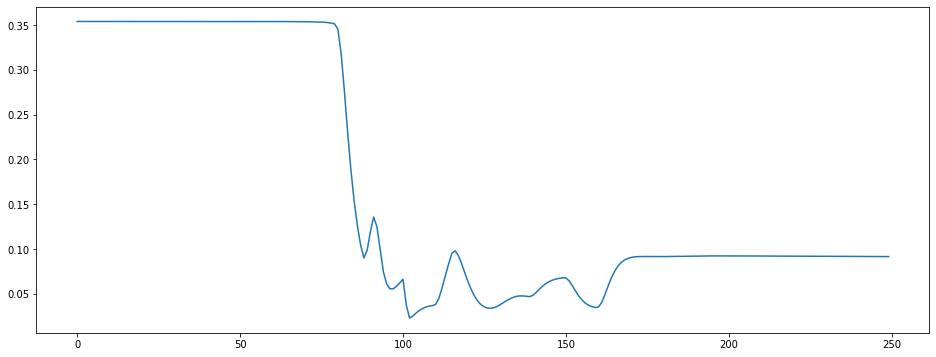

In [136]:
plt.plot(stocks['Transmission Rate'])

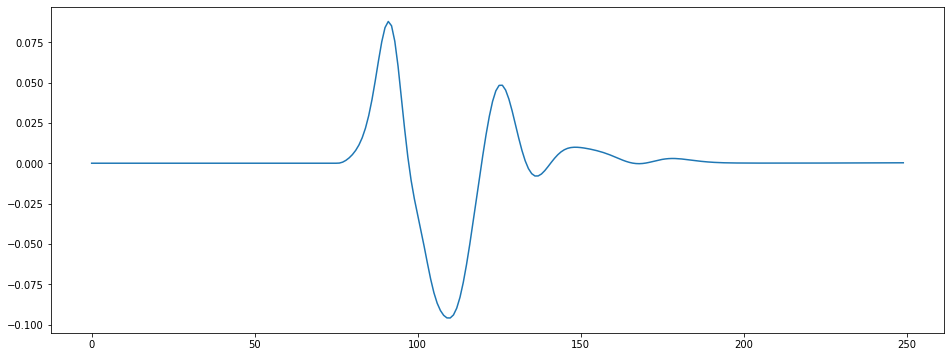

In [137]:
plt.plot(stocks['smooth aggregated'])

0.26948124521863875


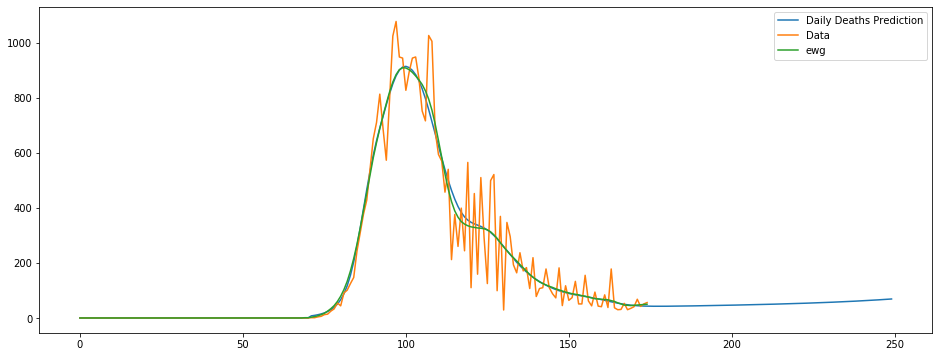

In [143]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.figure()
stocks.loc[0:70, 'Observed deaths'] = 0
plt.plot(stocks['Observed deaths'].values)
plt.plot(data_timeseries.index[0:today],data_timeseries.New_deaths.values[0:today])
plt.plot(data_timeseries.index[0:today],gaussian_filter(data_timeseries.New_deaths.values, sigma=3)[0:today])

plt.legend(['Daily Deaths Prediction','Data','ewg'])
#plt.yscale('log')
rms2 = sqrt(mean_squared_error(data_timeseries.New_deaths.values[30:today], stocks['Observed deaths'].values[30:today]))
print(rms2/data_timeseries.New_deaths.values[30:today].std())


0.013470068874665264


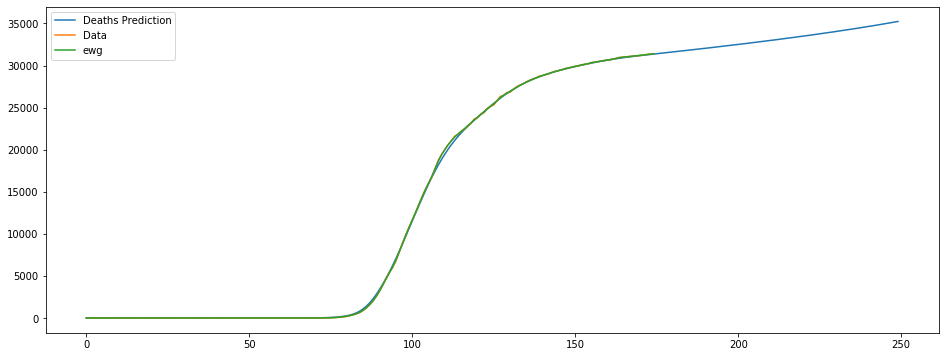

In [144]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.figure()
stocks.loc[0:70, 'Observed deaths'] = 0
plt.plot(stocks['Observed deaths'].cumsum().values)
plt.plot(data_timeseries.index[0:today],data_timeseries.Total_deaths.values[0:today])
plt.plot(data_timeseries.index[0:today],gaussian_filter(data_timeseries.Total_deaths.values, sigma=1)[0:today])

plt.legend(['Deaths Prediction','Data','ewg'])
#plt.yscale('log')
rms2 = sqrt(mean_squared_error(data_timeseries.Total_deaths.values[30:today], stocks['Deaths'][30:today]))
print(rms2/data_timeseries.Total_deaths.values[30:today].mean())

0.6093467460688621


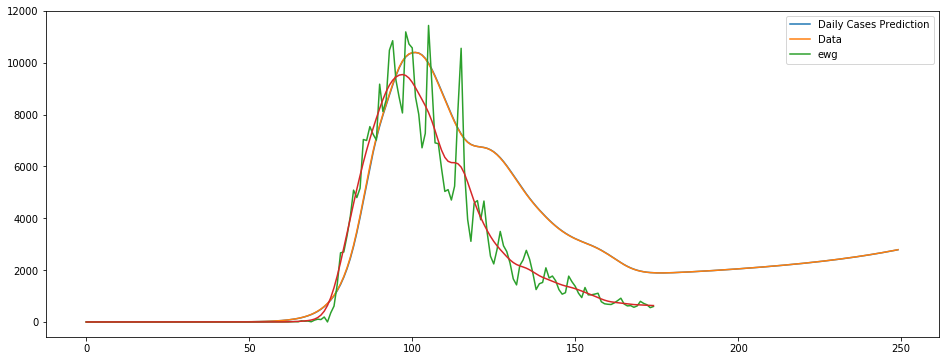

In [145]:
##### plt.rcParams['figure.figsize'] = [16, 6]
plt.figure()
stocks.loc[0:50, 'Observing Cases'] = 0
plt.plot(stocks['Observing Cases'].values)
plt.plot(stocks['Observed Cases Model'].values)
plt.plot(data_timeseries.index[0:today],data_timeseries.New_cases.values[0:today])
plt.plot(data_timeseries.index[0:today],gaussian_filter(data_timeseries.New_cases.values, sigma=3)[0:today])
#print(stocks['Observing Cases'][50:today])
plt.legend(['Daily Cases Prediction','Data','ewg'])
#plt.yscale('log')
rms2 = sqrt(mean_squared_error(data_timeseries.New_cases.values[50:today], stocks['Observing Cases'][50:today]))
print(rms2/data_timeseries.New_cases.values[50:today].std())

23.480642359974677


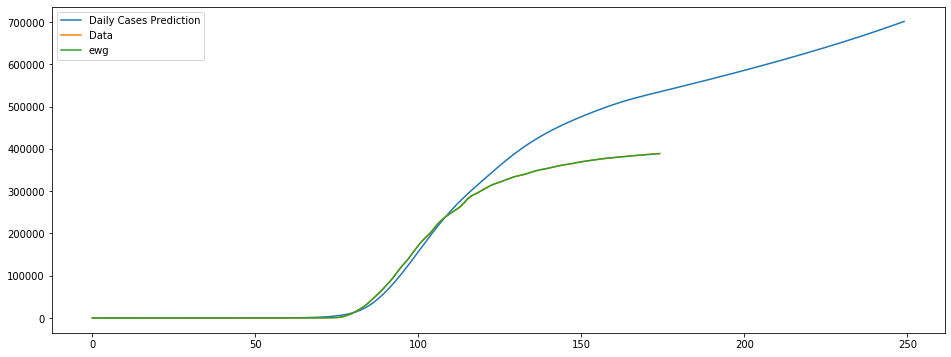

In [146]:
plt.rcParams['figure.figsize'] = [16, 6]
stocks.loc[0:40, 'Observing Cases'] = 0
plt.figure()
plt.plot(stocks['Observing Cases'].values.cumsum())
plt.plot(data_timeseries.index[0:today],data_timeseries.Total_cases.values[0:today])
plt.plot(data_timeseries.index[0:today],gaussian_filter(data_timeseries.Total_cases.values, sigma=1)[0:today])

plt.legend(['Daily Cases Prediction','Data','ewg'])
#plt.yscale('log')
rms2 = sqrt(mean_squared_error(data_timeseries.Total_cases.values[30:today], stocks['Observing Cases'].values[30:today].cumsum()))
print(rms2/data_timeseries.New_cases.values[30:today].mean())

In [148]:
dates_index2 = pd.date_range(start="01-01-2020", end='31-08-2020')
data_to_see_pred=pd.DataFrame()
data_to_see_pred['Total_deaths_pred'] = stocks['Observed deaths'].cumsum().values
data_to_see_pred['Daily_deaths_pred'] = stocks['Observed deaths'].values

In [149]:
data_to_see_pred = pd.concat([data_to_see_pred,data_timeseries[['Total_deaths','New_deaths']]], ignore_index=True, axis=1)

In [150]:
names={0: "Total_deaths_pred", 1: "Daily_deaths_pred",
       2: "Total_deaths", 3: "New_deaths"}
data_to_see_pred = data_to_see_pred.rename(columns=names)

In [151]:
data_to_see_pred

,Total_deaths_pred,Daily_deaths_pred,Total_deaths,New_deaths
0,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.0,0.0
5,0.000000,0.000000,0.0,0.0
6,0.000000,0.000000,0.0,0.0
7,0.000000,0.000000,0.0,0.0
8,0.000000,0.000000,0.0,0.0
9,0.000000,0.000000,0.0,0.0


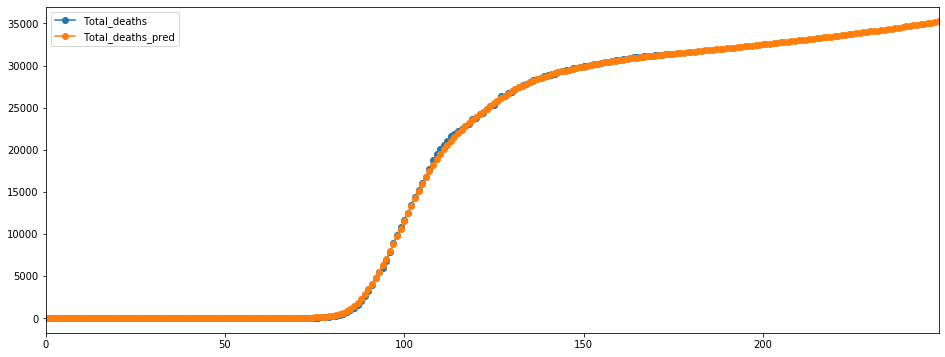

In [152]:
data_to_see_pred[['Total_deaths','Total_deaths_pred']].plot(marker='o')

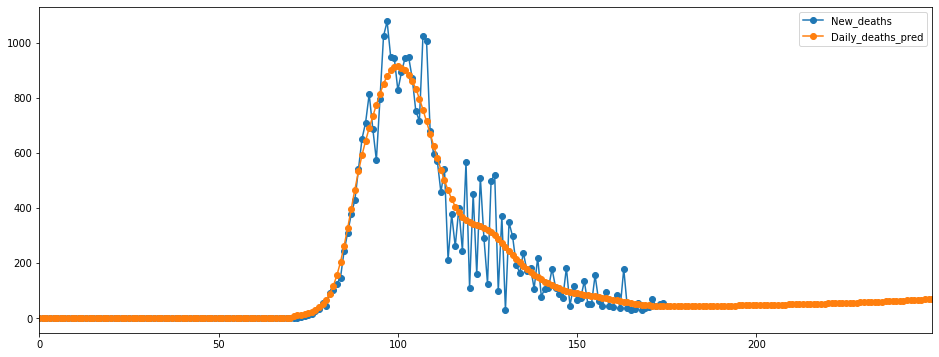

In [153]:
data_to_see_pred[['New_deaths','Daily_deaths_pred']].plot(marker='o')

In [621]:
parameters_initial={}

parameters_initial['final_time'] = 365
parameters_initial['initial_population'] = from_names_to_pop[country]

################ importing ############################
parameters_initial['initial_n_imported_infections'] = 100
parameters_initial['real_import_time'] = 32
parameters_initial['duration_importing'] = 15

parameters_initial['behavioral_risk_reduction'] = 0.80
parameters_initial['first_lockdown_measures_time'] =74
parameters_initial['behavior_reaction_time'] = 5


################ hospital ############################
parameters_initial['initial_hospital_capacity'] = 4500
parameters_initial['final_hospital_capacity'] = 20000
parameters_initial['hospital_increase_time'] = 60
parameters_initial['duration_hospital'] = 40
parameters_initial['hospital_capacity_sensitivity'] = 2


################ health ##############################
parameters_initial['duration_of_health'] = 15
parameters_initial['health_increase_time'] = 70
parameters_initial['intitial_health_capacity'] = 5000
parameters_initial['final_of_health_capacity'] = 10000
parameters_initial['public_health_capacity_sensitivity'] = 2

############## isolation #############################
parameters_initial['first_case_time'] = 75
parameters_initial['isolation_reaction_time'] = 2
parameters_initial['potential_isolation_effectiveness'] = 0.15
parameters_initial['delay_time_observing_cases'] = 1



parameters_initial['fraction_requiring_hospitalization'] = 0.15
parameters_initial['fraction_of_recovered'] = 0.20
parameters_initial['franction_infecting'] = 0.25

################# perception ######################
parameters_initial['reaction_time_of_behavior'] = 5
parameters_initial['time_to_adjust'] = 75
parameters_initial['carrying_capacity_of_cases'] = 1000
parameters_initial['carrying_capacity_of_deaths'] = 100
parameters_initial['w_per_cases'] = 2
parameters_initial['w_per_deaths'] =0


################# season ######################
parameters_initial['seasonal_amplitude'] = 0.20
parameters_initial['peak_season'] = 1

################# Fatality #######################
parameters_initial['treated_fatality_rate'] = 0.018
parameters_initial['untreated_fatality_multiplier'] = 0.12
parameters_initial['incubation_time'] = 2.5
parameters_initial['onset_time'] = 4.2
parameters_initial['infection_duration'] = 16.1

################## delay times #################
parameters_initial['fraction_of_recovered'] = 0.15
parameters_initial['delay_time_recovered'] = 1
parameters_initial['delay_time_deaths'] =1
parameters_initial['delay_time_observing_cases'] = 0.1
     
############## Testing ##########################
parameters_initial['final_testing'] = 10
parameters_initial['testing_change_time'] = 67
parameters_initial['duration_of_testing'] = 11

parameters_initial['w_exp'] = 0.00
parameters_initial['w_inf_s'] =0.00#.03406981#0.06368263 #0.05960604#0.0383558
parameters_initial['w_inf'] = 0.01#0.03654988#0.02363193 #0.02383615#0.02886392


In [622]:
stocks = model.run(return_timestamps=range(0,180),params=parameters_initial)

In [623]:

################ importing ############################
parameters_initial['initial_n_imported_infections'] = 100
parameters_initial['real_import_time'] = 32
parameters_initial['duration_importing'] = 15

parameters_initial['behavioral_risk_reduction'] = 0.79
parameters_initial['first_lockdown_measures_time'] =74
parameters_initial['behavior_reaction_time'] = 5

del stocks

stocks = model.run(return_timestamps=range(0,84),params=parameters_initial)
temp = model.run(initial_condition=(83, {'behavioral_risk_reduction':0.38,
                                          'first_lockdown_measures_time':83,
                                          'behavior_reaction_time':4}),
                 return_timestamps=range(84,88))
temp1 = model.run(initial_condition=(87, {'behavioral_risk_reduction':0.99,
                                          'first_lockdown_measures_time':87,
                                          'behavior_reaction_time':4}),
                 return_timestamps=range(88,95))
temp2 = model.run(initial_condition=(94, {'behavioral_risk_reduction':0.99,
                                          'first_lockdown_measures_time':94,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(95,101))
temp3 = model.run(initial_condition=(100, {'behavioral_risk_reduction':1.00,
                                          'first_lockdown_measures_time':100,
                                          'behavior_reaction_time':1}),
                 return_timestamps=range(101,108))
temp4 = model.run(initial_condition=(107, {'behavioral_risk_reduction':0.55,
                                          'first_lockdown_measures_time':107,
                                          'behavior_reaction_time':2}),
                 return_timestamps=range(108,110))
temp5 = model.run(initial_condition=(109, {'behavioral_risk_reduction':1.0,
                                          'first_lockdown_measures_time':109,
                                          'behavior_reaction_time':1}),
                 return_timestamps=range(110,123))
temp6 = model.run(initial_condition=(122, {'behavioral_risk_reduction':0.79,
                                          'first_lockdown_measures_time':122,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(123,139))
temp7 = model.run(initial_condition=(138, {'behavioral_risk_reduction':0.88,
                                          'first_lockdown_measures_time':138,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(139,150))
temp8 = model.run(initial_condition=(149, {'behavioral_risk_reduction':0.90,
                                          'first_lockdown_measures_time':149,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(150,160))
temp9 = model.run(initial_condition=(159, {'behavioral_risk_reduction':0.70,
                                          'first_lockdown_measures_time':159,
                                          'behavior_reaction_time':5}),
                 return_timestamps=range(160,250))



stocks=stocks.append(temp)
stocks=stocks.append(temp1)
stocks=stocks.append(temp2)
stocks=stocks.append(temp3)
stocks=stocks.append(temp4)
stocks=stocks.append(temp5)
stocks=stocks.append(temp6)
stocks=stocks.append(temp7)
stocks=stocks.append(temp8)
stocks=stocks.append(temp9)

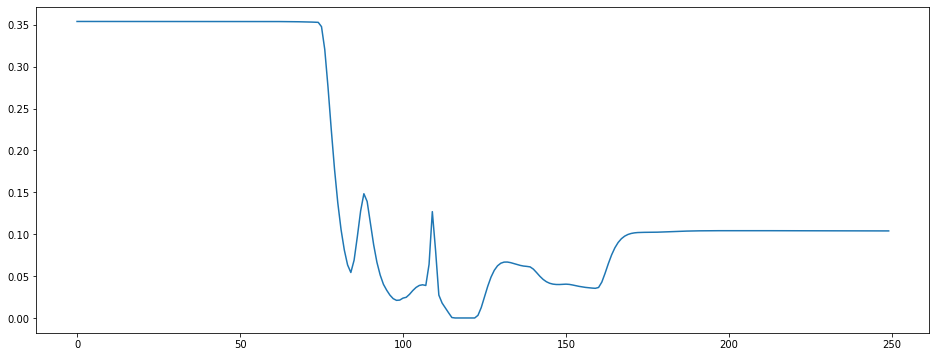

In [624]:
plt.plot(stocks['Transmission Rate'])

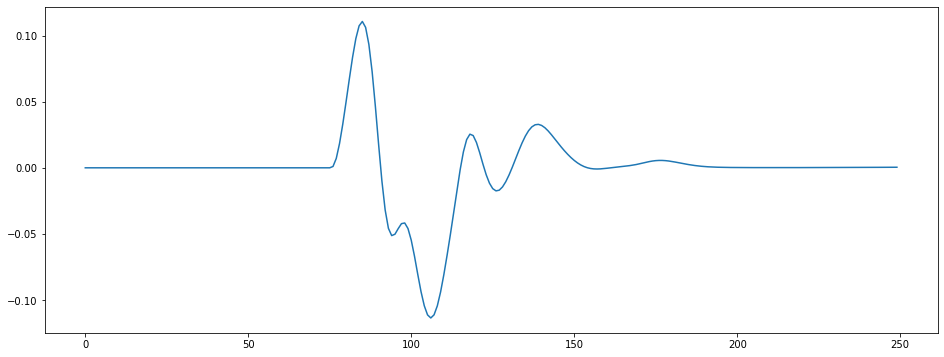

In [625]:
plt.plot(stocks['smooth aggregated'])

0.25478009534063917


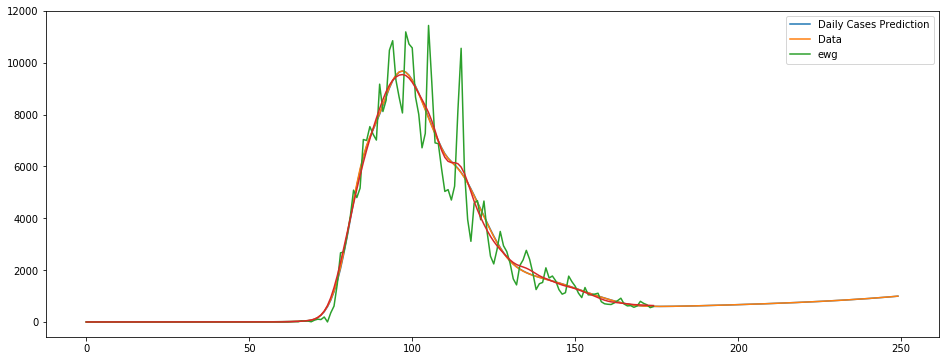

In [626]:
##### plt.rcParams['figure.figsize'] = [16, 6]
plt.figure()
stocks.loc[0:45, 'Observing Cases'] = 0
plt.plot(stocks['Observing Cases'].values)
plt.plot(stocks['Observed Cases Model'].values)
plt.plot(data_timeseries.index[0:today],data_timeseries.New_cases.values[0:today])
plt.plot(data_timeseries.index[0:today],gaussian_filter(data_timeseries.New_cases.values, sigma=3)[0:today])
#print(stocks['Observing Cases'][50:today])
plt.legend(['Daily Cases Prediction','Data','ewg'])
#plt.yscale('log')
rms2 = sqrt(mean_squared_error(data_timeseries.New_cases.values[50:today], stocks['Observing Cases'][50:today]))
print(rms2/data_timeseries.New_cases.values[50:today].std())

0.5056801870594607


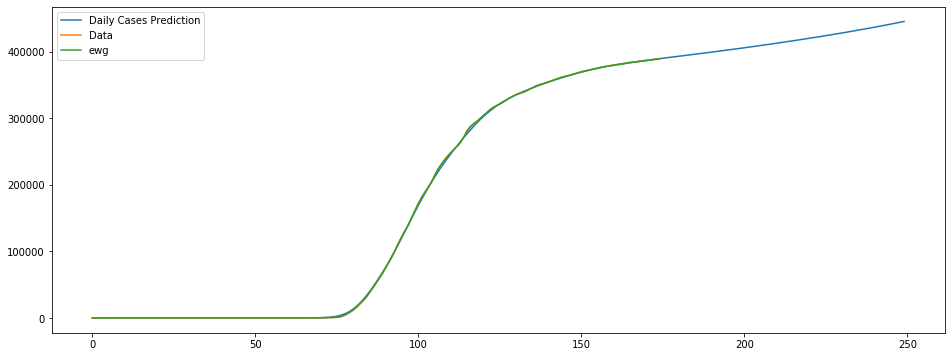

In [627]:
plt.rcParams['figure.figsize'] = [16, 6]
stocks.loc[0:40, 'Observing Cases'] = 0
plt.figure()
plt.plot(stocks['Observing Cases'].values.cumsum())
plt.plot(data_timeseries.index[0:today],data_timeseries.Total_cases.values[0:today])
plt.plot(data_timeseries.index[0:today],gaussian_filter(data_timeseries.Total_cases.values, sigma=1)[0:today])

plt.legend(['Daily Cases Prediction','Data','ewg'])
#plt.yscale('log')
rms2 = sqrt(mean_squared_error(data_timeseries.Total_cases.values[30:today], stocks['Observing Cases'].values[30:today].cumsum()))
print(rms2/data_timeseries.New_cases.values[30:today].mean())

In [628]:
data_to_see_pred['Total_cases_pred'] = stocks['Observing Cases'].cumsum().values
data_to_see_pred['Daily_cases_pred'] = stocks['Observing Cases'].values

In [629]:
data_to_see_pred = pd.concat([data_to_see_pred,data_timeseries[['Total_cases','New_cases']]], ignore_index=True, axis=1)

In [630]:
names={0: "Total_deaths_pred", 1: "Daily_deaths_pred",
       2: "Total_deaths", 3: "New_deaths",
       4: "Total_cases_pred", 5: "Daily_cases_pred",
       6: "Total_cases", 7: "New_cases"}
data_to_see_pred = data_to_see_pred.rename(columns=names)

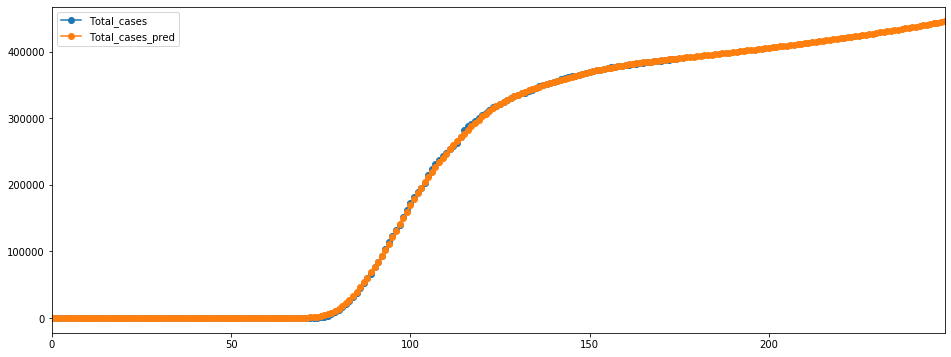

In [631]:
data_to_see_pred[['Total_cases','Total_cases_pred']].plot(marker='o')

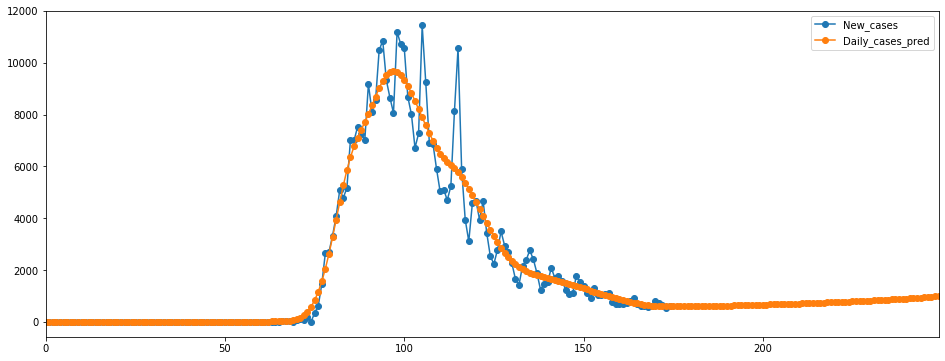

In [632]:
data_to_see_pred[['New_cases','Daily_cases_pred']].plot(marker='o')

In [633]:
data_to_write_pred = pd.DataFrame()
data_to_write_pred['Date'] = dates_index2
data_to_write_pred['Total_cases_pred'] = data_to_see_pred['Total_cases_pred']
data_to_write_pred['Daily_cases_pred'] = data_to_see_pred['Daily_cases_pred']
data_to_write_pred['Total_deaths_pred'] = data_to_see_pred['Total_deaths_pred']
data_to_write_pred['Daily_deaths_pred'] = data_to_see_pred['Daily_deaths_pred']
data_to_write_pred = data_to_write_pred.set_index('Date')
data_to_write_pred

,Total_cases_pred,Daily_cases_pred,Total_deaths_pred,Daily_deaths_pred
Date,,,,
2020-01-01,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000,0.000000
2020-01-04,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.000000,0.000000,0.000000,0.000000
2020-01-07,0.000000,0.000000,0.000000,0.000000
2020-01-08,0.000000,0.000000,0.000000,0.000000
2020-01-09,0.000000,0.000000,0.000000,0.000000


In [634]:
data_to_write_pred.to_json('../../../data/predictions/USA/'+country+'_pred.json')